## Generate 2D features for IE dataset

### Using RDKit/MORDRED

**Created on 19th May, 2022; modified on 4th January, 2023**

In [9]:
import warnings
warnings.filterwarnings('ignore')
#from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
#import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, LassoCV, \
    RidgeClassifier, Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR, SVC
from sklearn.gaussian_process import GaussianProcessRegressor, GaussianProcessClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel, WhiteKernel, \
RationalQuadratic, ExpSineSquared, DotProduct
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, \
precision_score, auc
import sys, os, csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import pickle
import optuna
from rdkit import Chem
from ifg import identify_functional_groups ## Need ifg.py file
import rdkit.Chem.Crippen as Crippen
import rdkit.Chem.rdMolDescriptors as MolDescriptors
import rdkit.Chem.Descriptors as Descriptors
import rdkit.Chem.Lipinski as Lipinski
from rdkit.Chem import Descriptors3D
from rdkit.Chem import AllChem, DataStructs, Fragments
from mordred import Calculator, descriptors, CPSA
from mordred.GeometricalIndex import Radius3D, Diameter3D, GeometricalShapeIndex

In [2]:
%%bash
pwd
ls -ltr

/Users/riteshkumar/Library/CloudStorage/Box-Box/Research-postdoc/liquid-electrolyte-ML/redox-stability/lgbm_01-04-23/feat-gen
total 5528
-rw-r--r--@ 1 riteshkumar  staff  917505 Jan  4 18:05 final_MP_red4.csv
-rw-r--r--  1 riteshkumar  staff  733867 Jan  4 18:05 train_random.csv
-rw-r--r--  1 riteshkumar  staff   91329 Jan  4 18:06 val_random.csv
-rw-r--r--  1 riteshkumar  staff   92335 Jan  4 18:06 test_random.csv
-rw-r--r--@ 1 riteshkumar  staff    4144 Jan  4 18:06 ifg.py
-rw-r--r--@ 1 riteshkumar  staff  972128 Jan  4 18:06 generate_functional_grp+rdkit_feat.ipynb
drwxr-xr-x  3 riteshkumar  staff      96 Jan  4 18:06 __pycache__


In [3]:
df = pd.read_csv('final_MP_red4.csv')
df

,smiles,IE,EA
0,C(C#CC(C)C)(C)C,5.481535,-0.771096
1,C(=O)=O,9.433272,0.941193
2,O,7.902121,-1.343401
3,C(=C\C)/C(C)C,5.085723,-1.005246
4,c1(c(ccc(c1)C)C)C,4.733493,-0.843508
...,...,...,...
18128,c1cc(c2c(c1)[nH]sn2N(=O)=O)C(=O)O,3.220508,3.856206
18129,CC(=O)c1ccc2c(c1C#N)[nH]s[nH]2,3.620069,1.502602
18130,CCn1c2ccc(cc2[nH]s1)Cl,3.308856,2.027702
18131,CCc1ccc2c(c1O)[nH]s[nH]2,3.476727,2.415027


In [4]:
df_train = pd.read_csv('train_random.csv')
df_val = pd.read_csv('val_random.csv')
df_test = pd.read_csv('test_random.csv')
df_train

,smiles,IE,EA
0,COCCOc1cscc1OC,4.306098,-0.316860
1,c1c(c2c(cc1)nccn2)C(=O)O,5.330098,1.630650
2,C=Cc1cccc2c1[nH]sn2OCCOC,3.957699,3.737185
3,c1ccc(cc1)C1(CCCC1)O,5.178552,-0.684359
4,C(#N)C1=COC(=CO1)N,3.910692,0.658757
...,...,...,...
14500,CC(C)(C)c1cc(C#N)c2c(c1)ONO2,4.638594,0.800909
14501,C=Cc1cscc1F,4.756748,0.466087
14502,n1c(cncc1C)C,5.327466,0.645181
14503,c1ccc(cc1)[C@@H]1[C@H](C(=O)O)SCCS1,4.915535,0.891338


#### Functional group features

Not using the fgrp ids from this list as it generates >2000

In [11]:
all_functional_groups_solv = []
for i in range(len(df)):
    smile = df['smiles'][i]
    # print(smile)
    mol = Chem.MolFromSmiles(smile)
    functional_group = identify_functional_groups(mol)
    for j in range(len(functional_group)):
        all_functional_groups_solv.append(functional_group[j].atoms)
unique_functional_groups_solv = list(set(all_functional_groups_solv))
unique_functional_groups_solv

['OC1=CC(=C2C=CNC=C2)C=C(Cl)N1',
 'FC=C=C(F)S',
 'C=CC(N)N',
 '[N][Na]',
 'NCN1C=CC(=C2C=CN(C/N=C/O)C=C2)C=C1',
 'C=CC(Cl)=CCl',
 'O=[N+]([O-])C1=CC(=C2C=CNC=C2)C=CN1C/N=C/O',
 'C#CC1=C(N)SC(=C2SC=CS2)S1',
 'C=CC(=C)SC(=C)C=C',
 'O=C1C=CC(=O)C(=O)C=C1',
 'C=C/S',
 'O=[N+]([O-])C1=COC(F)=CO1',
 'N=CNC(=N)C(N)=O',
 'NC=O',
 'NCN1C=CC(=C2C=CNC=C2/N=C\\O)C=C1',
 'FC1=CNC=C/C1=C1/C=CNC=C1F',
 'O=CC1=C/C(=C2\\C=CNC=C2C(=O)O)C=CN1',
 'N#CC1=C(O)NC=CC1=C1C=CNC=C1',
 'C=CC=O',
 'C=CC1=C(N)C(=C2C=CNC=C2)C=CN1',
 'C#CNSN',
 'C#CC1=CSC(C(=O)O)=CS1',
 'N#CC1=COC(C#N)=CO1',
 'O=[N+]([O-])C=COC=CO',
 'NC1=CC(=C2C=CNC=C2)C=C(C=O)N1',
 'OCN1C=CC(=C2C=CNC=C2Cl)C=C1',
 'C=N\\O',
 'C=COC(C=C)=CC(=O)O',
 'NC1=CS/C(=C2/SC=C(Cl)S2)S1',
 'O=C(O)C1=C/C(=C2/C=CNC=C2)C=CN1',
 'N=CF',
 'C=CSC(C=C)=CN',
 'C=COC(=CN)C(=N)O',
 'C=C[Si](Cl)(C=C)C=C',
 'O=C(O)\\C=N/O',
 'O=[N+]([O-])C1=C(O)NC=CC1=C1C=CNC=C1',
 'C#CC1=CSC(C#N)=CS1',
 'NC1=C(N)SC=CS1',
 'FB(F)F',
 'C#CC1=C/C(=C2\\C=CNC(C(=O)O)=C2)C=CN1',
 'N#CC1=CNC(/N=

In [12]:
len(unique_functional_groups_solv)

2167

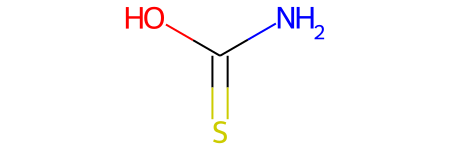

In [25]:
Chem.MolFromSmiles('NC(O)=S')

In [19]:
## Assign identifier to each type of functional group in solvent --> changing everytime I run
# dict_identifier_solv = {}
# for i in range(len(unique_functional_groups_solv)):
#     dict_identifier_solv[unique_functional_groups_solv[i]] = i+1
# dict_identifier_solv

{'S': 1,
 'o': 2,
 'O=[N+][O-]': 3,
 'OB(O)O': 4,
 'Cl': 5,
 'F[Si]': 6,
 'nnn': 7,
 'NC(N)=S': 8,
 'C=O': 9,
 'O': 10,
 'O=S=O': 11,
 'NC=O': 12,
 'O[Si]': 13,
 'C=C': 14,
 'NS(=O)=O': 15,
 '[Si]O[Si]': 16,
 'NC(N)=O': 17,
 'O=S(O)O': 18,
 'O=C(O)O': 19,
 'O[Si](O)O': 20,
 'C=CS(=O)=O': 21,
 'F[Si]F': 22,
 'O=CC(=O)O': 23,
 '[Si]O[Si]O[Si]': 24,
 'O=P(O)O': 25,
 'OB(O)B(O)O': 26,
 'O=S': 27,
 'OBO': 28,
 'O[Si]O': 29,
 'O=S(=O)F': 30,
 'OCO': 31,
 'OC(O)O': 32,
 'O=S(=O)[N-]S(=O)=O': 33,
 'F': 34,
 '[Si]': 35,
 'C#N': 36,
 'O=CO': 37,
 'NC(O)=S': 38,
 'C=CC#N': 39,
 'n': 40,
 '[N+]': 41,
 'O=P(O)(O)O': 42}

Calculate functional group features for solvent

In [5]:
df_solv = pd.read_csv('solvent_functional_group_identifier.csv')
df_solv

,S,o,O=[N+][O-],OB(O)O,Cl,F[Si],nnn,NC(N)=S,C=O,O,...,O=S(=O)[N-]S(=O)=O,F,[Si],C#N,O=CO,NC(O)=S,C=CC#N,n,[N+],O=P(O)(O)O
0,1,2,3,4,5,6,7,8,9,10,...,33,34,35,36,37,38,39,40,41,42


In [6]:
unique_functional_groups_solv = list(df_solv.columns)
unique_functional_groups_solv

['S',
 'o',
 'O=[N+][O-]',
 'OB(O)O',
 'Cl',
 'F[Si]',
 'nnn',
 'NC(N)=S',
 'C=O',
 'O',
 'O=S=O',
 'NC=O',
 'O[Si]',
 'C=C',
 'NS(=O)=O',
 '[Si]O[Si]',
 'NC(N)=O',
 'O=S(O)O',
 'O=C(O)O',
 'O[Si](O)O',
 'C=CS(=O)=O',
 'F[Si]F',
 'O=CC(=O)O',
 '[Si]O[Si]O[Si]',
 'O=P(O)O',
 'OB(O)B(O)O',
 'O=S',
 'OBO',
 'O[Si]O',
 'O=S(=O)F',
 'OCO',
 'OC(O)O',
 'O=S(=O)[N-]S(=O)=O',
 'F',
 '[Si]',
 'C#N',
 'O=CO',
 'NC(O)=S',
 'C=CC#N',
 'n',
 '[N+]',
 'O=P(O)(O)O']

In [7]:
## Assign identifier to each type of functional group in solvent --> changing everytime I run
dict_identifier_solv = {}
for i in range(len(unique_functional_groups_solv)):
    dict_identifier_solv[unique_functional_groups_solv[i]] = i+1
dict_identifier_solv

{'S': 1,
 'o': 2,
 'O=[N+][O-]': 3,
 'OB(O)O': 4,
 'Cl': 5,
 'F[Si]': 6,
 'nnn': 7,
 'NC(N)=S': 8,
 'C=O': 9,
 'O': 10,
 'O=S=O': 11,
 'NC=O': 12,
 'O[Si]': 13,
 'C=C': 14,
 'NS(=O)=O': 15,
 '[Si]O[Si]': 16,
 'NC(N)=O': 17,
 'O=S(O)O': 18,
 'O=C(O)O': 19,
 'O[Si](O)O': 20,
 'C=CS(=O)=O': 21,
 'F[Si]F': 22,
 'O=CC(=O)O': 23,
 '[Si]O[Si]O[Si]': 24,
 'O=P(O)O': 25,
 'OB(O)B(O)O': 26,
 'O=S': 27,
 'OBO': 28,
 'O[Si]O': 29,
 'O=S(=O)F': 30,
 'OCO': 31,
 'OC(O)O': 32,
 'O=S(=O)[N-]S(=O)=O': 33,
 'F': 34,
 '[Si]': 35,
 'C#N': 36,
 'O=CO': 37,
 'NC(O)=S': 38,
 'C=CC#N': 39,
 'n': 40,
 '[N+]': 41,
 'O=P(O)(O)O': 42}

In [8]:
## Define the function for calculating number of fragments
## of the functional groups present in a query solvent
def calc_frag_fg_solvent(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fgs = identify_functional_groups(mol)
    counter_1 = 0; counter_2 = 0; counter_3 = 0; counter_4 = 0
    counter_5 = 0; counter_6 = 0; counter_7 = 0; counter_8 = 0
    counter_9 = 0; counter_10 = 0; counter_11 = 0; counter_12 = 0
    counter_13 = 0; counter_14 = 0; counter_15 = 0; counter_16 = 0
    counter_17 = 0; counter_18 = 0; counter_19 = 0; counter_20 = 0
    counter_21 = 0; counter_22 = 0; counter_23 = 0; counter_24 = 0
    counter_25 = 0; counter_26 = 0; counter_27 = 0; counter_28 = 0
    counter_29 = 0; counter_30 = 0; counter_31 = 0; counter_32 = 0
    # counter_33 = 0; counter_34 = 0; counter_35 = 0                  ## has 35 identifiers for single component electrolytes
    counter_33 = 0; counter_34 = 0; counter_35 = 0; counter_36 = 0
    counter_37 = 0; counter_38 = 0; counter_39 = 0; counter_40 = 0
    counter_41 = 0; counter_42 = 0
    for i in range(len(fgs)):
        if fgs[i].atoms == unique_functional_groups_solv[0]:
            counter_1 += 1
        elif fgs[i].atoms == unique_functional_groups_solv[1]:
            counter_2 += 1
        elif fgs[i].atoms == unique_functional_groups_solv[2]:
            counter_3 += 1
        elif fgs[i].atoms == unique_functional_groups_solv[3]:
            counter_4 += 1
        elif fgs[i].atoms == unique_functional_groups_solv[4]:
            counter_5 += 1
        elif fgs[i].atoms == unique_functional_groups_solv[5]:
            counter_6 += 1
        elif fgs[i].atoms == unique_functional_groups_solv[6]:
            counter_7 += 1
        elif fgs[i].atoms == unique_functional_groups_solv[7]:
            counter_8 += 1
        elif fgs[i].atoms == unique_functional_groups_solv[8]:
            counter_9 += 1
        elif fgs[i].atoms == unique_functional_groups_solv[9]:
            counter_10 += 1
        elif fgs[i].atoms == unique_functional_groups_solv[10]:
            counter_11 += 1
        elif fgs[i].atoms == unique_functional_groups_solv[11]:
            counter_12 += 1
        elif fgs[i].atoms == unique_functional_groups_solv[12]:
            counter_13 += 1
        elif fgs[i].atoms == unique_functional_groups_solv[13]:
            counter_14 += 1
        elif fgs[i].atoms == unique_functional_groups_solv[14]:
            counter_15 += 1
        elif fgs[i].atoms == unique_functional_groups_solv[15]:
            counter_16 += 1
        elif fgs[i].atoms == unique_functional_groups_solv[16]:
            counter_17 += 1
        elif fgs[i].atoms == unique_functional_groups_solv[17]:
            counter_18 += 1
        elif fgs[i].atoms == unique_functional_groups_solv[18]:
            counter_19 += 1
        elif fgs[i].atoms == unique_functional_groups_solv[19]:
            counter_20 += 1
        elif fgs[i].atoms == unique_functional_groups_solv[20]:
            counter_21 += 1
        elif fgs[i].atoms == unique_functional_groups_solv[21]:
            counter_22 += 1
        elif fgs[i].atoms == unique_functional_groups_solv[22]:
            counter_23 += 1
        elif fgs[i].atoms == unique_functional_groups_solv[23]:
            counter_24 += 1
        elif fgs[i].atoms == unique_functional_groups_solv[24]:
            counter_25 += 1
        elif fgs[i].atoms == unique_functional_groups_solv[25]:
            counter_26 += 1
        elif fgs[i].atoms == unique_functional_groups_solv[26]:
            counter_27 += 1
        elif fgs[i].atoms == unique_functional_groups_solv[27]:
            counter_28 += 1
        elif fgs[i].atoms == unique_functional_groups_solv[28]:
            counter_29 += 1
        elif fgs[i].atoms == unique_functional_groups_solv[29]:
            counter_30 += 1
        elif fgs[i].atoms == unique_functional_groups_solv[30]:
            counter_31 += 1
        elif fgs[i].atoms == unique_functional_groups_solv[31]:
            counter_32 += 1
        elif fgs[i].atoms == unique_functional_groups_solv[32]:
            counter_33 += 1
        elif fgs[i].atoms == unique_functional_groups_solv[33]:
            counter_34 += 1
        elif fgs[i].atoms == unique_functional_groups_solv[34]:
            counter_35 += 1
        elif fgs[i].atoms == unique_functional_groups_solv[35]:
            counter_36 += 1
        elif fgs[i].atoms == unique_functional_groups_solv[36]:
            counter_37 += 1
        elif fgs[i].atoms == unique_functional_groups_solv[37]:
            counter_38 += 1
        elif fgs[i].atoms == unique_functional_groups_solv[38]:
            counter_39 += 1
        elif fgs[i].atoms == unique_functional_groups_solv[39]:
            counter_40 += 1
        elif fgs[i].atoms == unique_functional_groups_solv[40]:
            counter_41 += 1
        elif fgs[i].atoms == unique_functional_groups_solv[41]:
            counter_42 += 1
    return counter_1, counter_2, counter_3, counter_4, \
        counter_5, counter_6, counter_7, counter_8, \
        counter_9, counter_10, counter_11, counter_12, \
        counter_13, counter_14, counter_15, counter_16, \
        counter_17, counter_18, counter_19, counter_20, \
        counter_21, counter_22, counter_23, counter_24, \
        counter_25, counter_26, counter_27, counter_28, \
        counter_29, counter_30, counter_31, counter_32, \
        counter_33, counter_34, counter_35, counter_36, \
        counter_37, counter_38, counter_39, counter_40, \
        counter_41, counter_42

In [21]:
calc_frag_fg_solvent('C1(C(OC(=O)O1)F)F')

(0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0)

In [12]:
def generate_features_solv(df):
    prop_vec = []
    for i in range(len(df)):
        smiles = df['smiles'][i]
        mol = Chem.MolFromSmiles(smiles)
        # print(smiles)
        # mol = Chem.MolFromSmiles(smiles_comb)
        fr_func_grp_1, fr_func_grp_2, fr_func_grp_3, fr_func_grp_4,\
        fr_func_grp_5, fr_func_grp_6, fr_func_grp_7, fr_func_grp_8,\
        fr_func_grp_9, fr_func_grp_10, fr_func_grp_11, fr_func_grp_12,\
        fr_func_grp_13, fr_func_grp_14, fr_func_grp_15, fr_func_grp_16,\
        fr_func_grp_17, fr_func_grp_18, fr_func_grp_19, fr_func_grp_20,\
        fr_func_grp_21, fr_func_grp_22, fr_func_grp_23, fr_func_grp_24,\
        fr_func_grp_25, fr_func_grp_26, fr_func_grp_27, fr_func_grp_28,\
        fr_func_grp_29, fr_func_grp_30, fr_func_grp_31, fr_func_grp_32,\
        fr_func_grp_33, fr_func_grp_32, fr_func_grp_35, fr_func_grp_36,\
        fr_func_grp_37, fr_func_grp_38, fr_func_grp_39, fr_func_grp_40,\
        fr_func_grp_41, fr_func_grp_42  = calc_frag_fg_solvent(smiles)
        mol_wt = MolDescriptors.CalcExactMolWt(mol)
        # hetero_num = MolDescriptors.CalcNumHeteroatoms(mol)
        # tot_num = MolDescriptors.CalcNumAtoms(mol)
        hba_num = MolDescriptors.CalcNumHBA(mol)
        ring_num = MolDescriptors.CalcNumRings(mol)
        heavy_num = MolDescriptors.CalcNumHeavyAtoms(mol)
        mol_sssr = Chem.GetSSSR(mol)
        clogp    = Crippen.MolLogP(mol)
        mr       = Crippen.MolMR(mol)
        tpsa    = MolDescriptors.CalcTPSA(mol)
        fracsp3  = MolDescriptors.CalcFractionCSP3(mol)
        hall_kier_alpha = MolDescriptors.CalcHallKierAlpha(mol)
        labute   = MolDescriptors.CalcLabuteASA(mol)
        valence_elec_num = Descriptors.NumValenceElectrons(mol)
        max_partial_charge = Descriptors.MaxPartialCharge(mol)
        min_partial_charge = Descriptors.MinPartialCharge(mol)
        vec = [smiles] + [fr_func_grp_1] + [fr_func_grp_2] + [fr_func_grp_3] + [fr_func_grp_4] + \
        [fr_func_grp_5] + [fr_func_grp_6] + [fr_func_grp_7] + [fr_func_grp_8] + \
        [fr_func_grp_9] + [fr_func_grp_10] + [fr_func_grp_11] + [fr_func_grp_12] + \
        [fr_func_grp_13] + [fr_func_grp_14] + [fr_func_grp_15] + [fr_func_grp_16] + \
        [fr_func_grp_17] + [fr_func_grp_18] + [fr_func_grp_19] + [fr_func_grp_20] + \
        [fr_func_grp_21] + [fr_func_grp_22] + [fr_func_grp_23] + [fr_func_grp_24] + \
        [fr_func_grp_25] + [fr_func_grp_26] + [fr_func_grp_27] + [fr_func_grp_28] + \
        [fr_func_grp_29] + [fr_func_grp_30] + [fr_func_grp_31] + [fr_func_grp_32] + \
        [fr_func_grp_33] + [fr_func_grp_32] + [fr_func_grp_35] + [fr_func_grp_36] + \
        [fr_func_grp_37] + [fr_func_grp_38] + [fr_func_grp_39] + [fr_func_grp_40] + \
        [fr_func_grp_41] + [fr_func_grp_42] + [mol_wt] + [heavy_num] + [hba_num] + [ring_num] + \
        [mol_sssr] + [clogp] + [mr] + [tpsa] + [fracsp3] + [hall_kier_alpha] + \
        [labute] + [valence_elec_num] + [max_partial_charge] + [min_partial_charge]
        prop_vec.append(vec)
    return prop_vec

In [10]:
solv_feature_names = ['smiles', 'fr_func_grp_1_solv', 'fr_func_grp_2_solv', 'fr_func_grp_3_solv', 'fr_func_grp_4_solv',\
'fr_func_grp_5_solv', 'fr_func_grp_6_solv', 'fr_func_grp_7_solv', 'fr_func_grp_8_solv',\
'fr_func_grp_9_solv', 'fr_func_grp_10_solv', 'fr_func_grp_11_solv', 'fr_func_grp_12_solv',\
'fr_func_grp_13_solv', 'fr_func_grp_14_solv', 'fr_func_grp_15_solv', 'fr_func_grp_16_solv',\
'fr_func_grp_17_solv', 'fr_func_grp_18_solv', 'fr_func_grp_19_solv', 'fr_func_grp_20_solv',\
'fr_func_grp_21_solv', 'fr_func_grp_22_solv', 'fr_func_grp_23_solv', 'fr_func_grp_24_solv',\
'fr_func_grp_25_solv', 'fr_func_grp_26_solv', 'fr_func_grp_27_solv', 'fr_func_grp_28_solv',\
'fr_func_grp_29_solv', 'fr_func_grp_30_solv', 'fr_func_grp_31_solv', 'fr_func_grp_32_solv',\
'fr_func_grp_33_solv', 'fr_func_grp_34_solv', 'fr_func_grp_35_solv', 'fr_func_grp_36_solv',\
'fr_func_grp_37_solv', 'fr_func_grp_38_solv', 'fr_func_grp_39_solv', 'fr_func_grp_40_solv',\
'fr_func_grp_41_solv', 'fr_func_grp_42_solv']
solv_feature_names += ['mol_wt', 'num_heavy_atom', 'num_HBA', 'num_rings']
solv_feature_names += ['mol_sssr', 'clogp', 'molar_refractivity', 'tpsa', 'frac_sp3' ,
                       'hall_kier_alpha', 'labute_ASA', 'num_valence_electron', 'max_partial_charge', 'min_partial_charge']

In [13]:
X_train = generate_features_solv(df_train)
X_val = generate_features_solv(df_val)
X_test = generate_features_solv(df_test)
X_train

[['COCCOc1cscc1OC',
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  3,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  188.050715244,
  12,
  4,
  1,
  1,
  1.7819000000000003,
  48.24200000000003,
  27.69,
  0.5,
  -0.74,
  75.87217053601553,
  68,
  0.1714665796910046,
  -0.4919933231079562],
 ['c1c(c2c(cc1)nccn2)C(=O)O',
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  2,
  0,
  0,
  174.042927432,
  13,
  3,
  2,
  2,
  1.3279999999999994,
  46.49730000000001,
  63.08,
  0.0,
  -1.9699999999999998,
  73.8730615797616,
  64,
  0.3374764948149606,
  -0.47758138542308914],
 ['C=Cc1cccc2c1[nH]sn2OCCOC',
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0

In [14]:
print(len(X_train[0]))
print(len(solv_feature_names))

57
57


In [15]:
train_df = pd.DataFrame(X_train)
train_df.columns = solv_feature_names
train_df['IE'] = df_train['IE']
train_df

,smiles,fr_func_grp_1_solv,fr_func_grp_2_solv,fr_func_grp_3_solv,fr_func_grp_4_solv,fr_func_grp_5_solv,fr_func_grp_6_solv,fr_func_grp_7_solv,fr_func_grp_8_solv,fr_func_grp_9_solv,...,clogp,molar_refractivity,tpsa,frac_sp3,hall_kier_alpha,labute_ASA,num_valence_electron,max_partial_charge,min_partial_charge,IE
0,COCCOc1cscc1OC,0,0,0,0,0,0,0,0,0,...,1.78190,48.2420,27.69,0.500000,-0.74,75.872171,68,0.171467,-0.491993,4.306098
1,c1c(c2c(cc1)nccn2)C(=O)O,0,0,0,0,0,0,0,0,0,...,1.32800,46.4973,63.08,0.000000,-1.97,73.873062,64,0.337476,-0.477581,5.330098
2,C=Cc1cccc2c1[nH]sn2OCCOC,0,0,0,0,0,0,0,0,0,...,2.70270,68.0537,33.73,0.272727,-1.17,99.445369,86,0.103226,-0.382191,3.957699
3,c1ccc(cc1)C1(CCCC1)O,0,0,0,0,0,0,0,0,0,...,2.44820,48.8068,20.23,0.454545,-0.82,73.044516,64,0.089612,-0.385172,5.178552
4,C(#N)C1=COC(=CO1)N,0,0,0,0,0,0,0,0,0,...,0.15578,28.1364,68.27,0.000000,-1.63,51.773543,46,0.237928,-0.445084,3.910692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14500,CC(C)(C)c1cc(C#N)c2c(c1)ONO2,0,0,0,0,0,0,0,0,0,...,2.04658,54.2487,54.28,0.363636,-1.73,88.327892,78,0.213150,-0.369549,4.638594
14501,C=Cc1cscc1F,0,0,0,0,0,0,0,0,0,...,2.53020,34.3680,0.00,0.000000,-0.63,51.277583,42,0.140567,-0.205425,4.756748
14502,n1c(cncc1C)C,0,0,0,0,0,0,0,0,0,...,1.09344,31.5060,25.78,0.333333,-0.92,48.600583,42,0.055846,-0.260951,5.327466
14503,c1ccc(cc1)[C@@H]1[C@H](C(=O)O)SCCS1,2,0,0,0,0,0,0,0,0,...,2.66090,65.5228,37.30,0.363636,-0.61,97.452258,80,0.317615,-0.480376,4.915535


In [16]:
val_df = pd.DataFrame(X_val)
val_df.columns = solv_feature_names
val_df['IE'] = df_val['IE']
val_df

,smiles,fr_func_grp_1_solv,fr_func_grp_2_solv,fr_func_grp_3_solv,fr_func_grp_4_solv,fr_func_grp_5_solv,fr_func_grp_6_solv,fr_func_grp_7_solv,fr_func_grp_8_solv,fr_func_grp_9_solv,...,clogp,molar_refractivity,tpsa,frac_sp3,hall_kier_alpha,labute_ASA,num_valence_electron,max_partial_charge,min_partial_charge,IE
0,CN1C[C@H](N(C)C[C@H]1N)N(=O)=O,0,0,0,0,0,0,0,0,0,...,-1.24880,44.0178,75.64,1.000000,-0.72,71.070664,70,0.280466,-0.314653,4.481108
1,C1=C[C@H](C(=C1)N)N,0,0,0,0,0,0,0,0,0,...,-0.27390,29.3858,52.04,0.200000,-0.76,42.493764,38,0.063096,-0.400495,3.293469
2,CCc1cnc(CC)cn1,0,0,0,0,0,0,0,0,0,...,1.60140,40.7880,25.78,0.500000,-0.92,61.330468,54,0.058368,-0.257810,5.273551
3,Cc1cc2c(cc1/N=C(/C)\O)ONO2,0,0,0,0,0,0,0,0,0,...,1.79372,50.9685,63.08,0.222222,-1.75,80.894984,74,0.197611,-0.496538,3.960204
4,C#Cc1c(C=C)nccn1,0,0,0,0,0,0,0,0,0,...,1.10090,40.0580,25.78,0.000000,-1.62,59.640090,48,0.138054,-0.252326,5.201518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1809,CC(C)(C)c1cc(c2c(c1)ONO2)C(F)(F)F,0,0,0,0,0,0,0,0,0,...,3.19370,54.5357,30.49,0.454545,-1.43,96.431918,94,0.419721,-0.369584,4.573617
1810,C/C(=N/c1ccsc1F)/O,0,0,0,0,0,0,0,0,0,...,2.49510,39.6748,32.59,0.166667,-0.90,61.656742,54,0.201737,-0.496537,4.353451
1811,C=Cc1ccc(N(C)C)s1,0,0,0,0,0,0,0,0,0,...,2.45710,48.7370,3.24,0.250000,-0.76,65.601765,54,0.090903,-0.369563,3.324745
1812,CCc1ccc2c(c1)ON(N)O2,0,0,0,0,0,0,0,0,0,...,1.02590,43.1024,47.72,0.250000,-1.26,70.360484,64,0.197614,-0.353755,3.235921


In [17]:
test_df = pd.DataFrame(X_test)
test_df.columns = solv_feature_names
test_df['IE'] = df_test['IE']
test_df

,smiles,fr_func_grp_1_solv,fr_func_grp_2_solv,fr_func_grp_3_solv,fr_func_grp_4_solv,fr_func_grp_5_solv,fr_func_grp_6_solv,fr_func_grp_7_solv,fr_func_grp_8_solv,fr_func_grp_9_solv,...,clogp,molar_refractivity,tpsa,frac_sp3,hall_kier_alpha,labute_ASA,num_valence_electron,max_partial_charge,min_partial_charge,IE
0,CCc1c(ccc2c1ONO2)OC,0,0,0,0,0,0,0,0,0,...,1.44840,46.7637,39.72,0.333333,-1.42,76.318973,70,0.202300,-0.496327,4.100620
1,O=COC[C@@H](C=O)C#N,0,0,0,0,0,0,0,0,1,...,-0.50192,27.1830,67.16,0.400000,-1.37,52.028189,48,0.292634,-0.466029,8.128354
2,C1[C@H]([C@H](CSC1)CC)CC,1,0,0,0,0,0,0,0,0,...,3.17570,49.5040,0.00,1.000000,0.35,68.776067,60,-0.003658,-0.161697,4.574026
3,C(=O)(N(O)c1ccccc1)c1ccccc1,0,0,0,0,0,0,0,0,0,...,2.72260,61.4800,40.54,0.000000,-2.13,93.523067,80,0.281484,-0.280662,4.600431
4,C[C@@]12[C@H]3N4[C@@H]1[C@]2(C)[C@@]34C,0,0,0,0,0,0,0,0,0,...,0.85130,34.0340,3.01,1.000000,-0.04,55.030355,48,0.042502,-0.286071,5.203414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1809,C(O)c1ccc(cc1)Cl,0,0,0,0,1,0,0,0,0,...,1.83230,37.3748,20.23,0.142857,-0.53,58.893845,48,0.068139,-0.391680,5.163176
1810,CCC1=COC=C(C#N)O1,0,0,0,0,0,0,0,0,0,...,1.64958,34.2400,42.25,0.285714,-1.43,59.163537,52,0.238068,-0.464407,4.477547
1811,C1CO[C@](C#N)(CO1)O,0,0,0,0,0,0,0,0,0,...,-0.75462,27.3338,62.48,0.800000,-0.63,52.607092,50,0.280664,-0.372224,6.066940
1812,CC(C)(C)c1ccc2c(c1)[nH]sn2N(=O)=O,0,0,0,0,0,0,0,0,0,...,2.97090,65.8291,58.41,0.400000,-1.43,98.212013,86,0.177580,-0.305088,4.017905


In [42]:
train_df.to_csv('train_fgrp_feat.csv', index=False)
val_df.to_csv('val_fgrp_feat.csv', index=False)
test_df.to_csv('test_fgrp_feat.csv', index=False)